In [1]:
from helper.synthesis import create_features_linspace
%load_ext autoreload
%autoreload 2

# import os
# path_parent = os.path.dirname(os.getcwd())
# os.chdir(path_parent)
# os.getcwd()

In [8]:
from analysis.gridbased import model

In [18]:
model_type = 'cnn'
models = model.init_model(model_type)

Model: "cnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            multiple                  240       
                                                                 
 dense_11 (Dense)            multiple                  1953      
                                                                 
 reshape_3 (Reshape)         multiple                  0         
                                                                 
 conv2d_2 (Conv2D)           multiple                  300       
                                                                 
 conv2d_3 (Conv2D)           multiple                  271       
                                                                 
Total params: 2,764
Trainable params: 2,764
Non-trainable params: 0
_________________________________________________________________


In [19]:
import os
os.getcwd()

'/Users/samaypanwar/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Uni/FYP/FYP-Code'

100%|██████████| 250/250 [07:28<00:00,  1.79s/it]


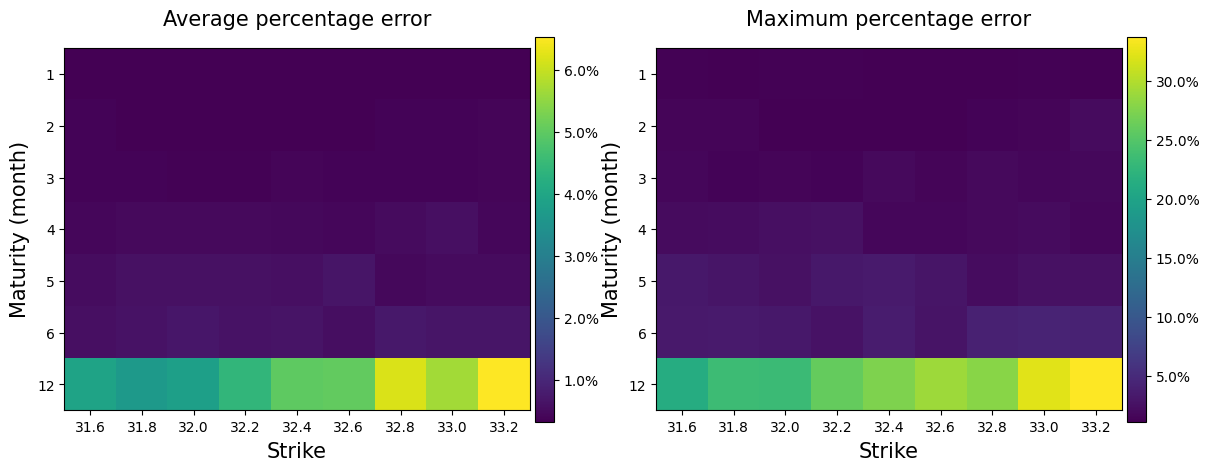

In [20]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
# print(os.getcwd())
model.train_model(models, epochs = 250, model_type = model_type)

In [21]:
model.load_weights(models, model_type = model_type)

In [22]:
params_range_train, params_range_test, price_train, price_test = model.load_data()

In [23]:
model.calibrate(model = models, prices = price_test, parameters = params_range_test, epochs = 1000, model_type = model_type)

100%|██████████| 1000/1000 [00:56<00:00, 17.79it/s]


In [1]:
from helper.synthesis import create_features_linspace
%load_ext autoreload
%autoreload 2


In [2]:
from analysis.pointwise import model

In [3]:
import os
os.getcwd()

'/Users/samaypanwar/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Uni/FYP/FYP-Code'

In [4]:
pointwise_models = model.init_model(model_type = 'dense')

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  300       
                                                                 
 dense_1 (Dense)             multiple                  930       
                                                                 
 dense_2 (Dense)             multiple                  930       
                                                                 
 dense_3 (Dense)             multiple                  31        
                                                                 
Total params: 2,191
Trainable params: 2,191
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 25/25 [00:11<00:00,  2.23it/s]


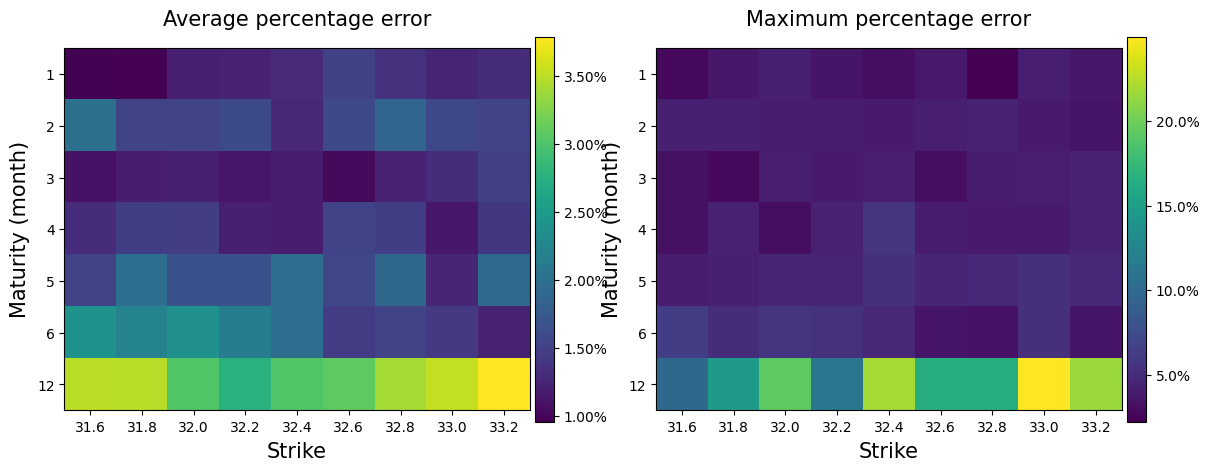

In [8]:
model.train_model(pointwise_models, epochs = 25, model_type = 'dense')

In [5]:
model.load_weights(pointwise_models)
params_range_train, params_range_test, price_train, price_test = model.load_data()

In [14]:
model.calibrate(model = pointwise_models, prices = price_test, parameters = params_range_test[1])

(4000, 7)


In [7]:
params_range_test.s

(4000, 9)